In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [2]:
# %% [code]
# Data Loading
train_path = "/kaggle/input/dbpedia-ontology-dataset/train.csv"
test_path  = "/kaggle/input/dbpedia-ontology-dataset/test.csv"

# Read CSV files assuming a header exists; columns are: label, title, content
train_df = pd.read_csv(train_path, header=0, low_memory=False)
test_df  = pd.read_csv(test_path, header=0, low_memory=False)

# Rename columns to be consistent (if needed)
train_df.columns = ['label', 'title', 'content']
test_df.columns  = ['label', 'title', 'content']

# Ensure label is an integer
train_df['label'] = train_df['label'].astype(int)
test_df['label'] = test_df['label'].astype(int)

print("Train set size:", train_df.shape)
print("Test set size:", test_df.shape)
train_df.head(3)


Train set size: (560000, 3)
Test set size: (70000, 3)


,label,title,content
0,0,E. D. Abbott Ltd,Abbott of Farnham E D Abbott Limited was a Br...
1,0,Schwan-Stabilo,Schwan-STABILO is a German maker of pens for ...
2,0,Q-workshop,Q-workshop is a Polish company located in Poz...


In [3]:
# %% [code]
# Data Overview Function (EDA)
def dataset_overview(df, name):
    print(f"Dataset: {name}")
    print("-" * 50)
    print(df.info())
    print(df.describe(include='all'))
    print("\nMissing values:\n", df.isnull().sum())
    print("\nDuplicate rows:", df.duplicated().sum())
    print("\n")

dataset_overview(train_df, "Train Set")
dataset_overview(test_df, "Test Set")


Dataset: Train Set
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560000 entries, 0 to 559999
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   label    560000 non-null  int64 
 1   title    560000 non-null  object
 2   content  560000 non-null  object
dtypes: int64(1), object(2)
memory usage: 12.8+ MB
None
                label                 title  \
count   560000.000000                560000   
unique            NaN                560000   
top               NaN  Hillsboro Free Press   
freq              NaN                     1   
mean         6.500000                   NaN   
std          4.031132                   NaN   
min          0.000000                   NaN   
25%          3.000000                   NaN   
50%          6.500000                   NaN   
75%         10.000000                   NaN   
max         13.000000                   NaN   

         

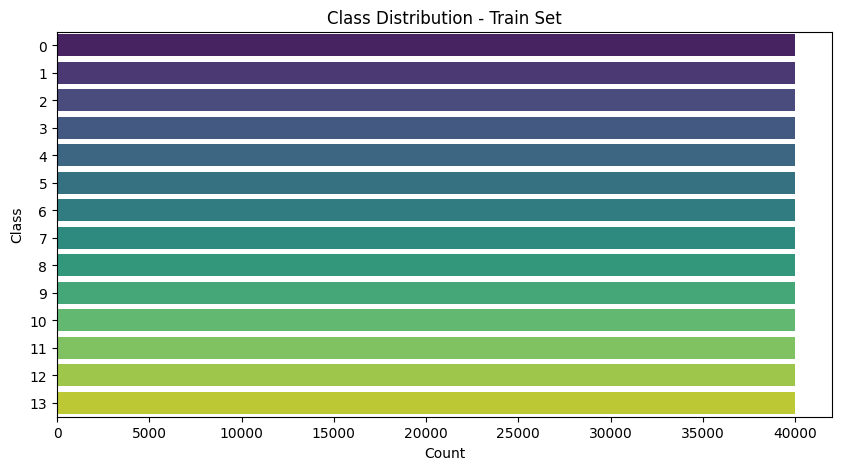

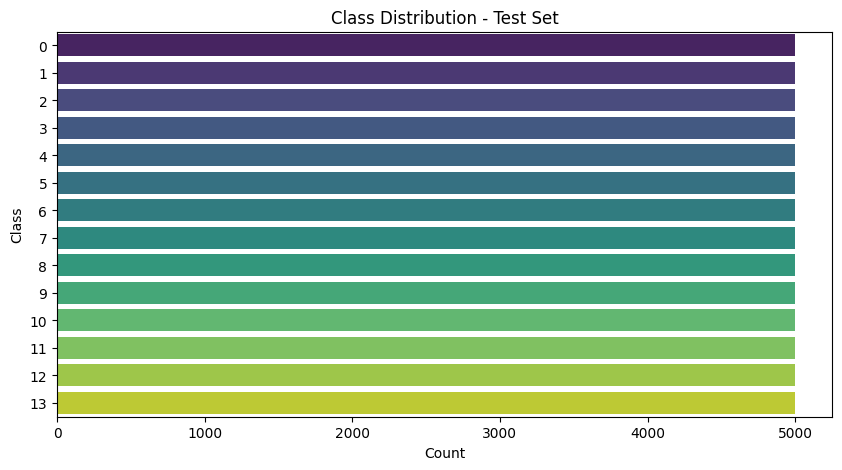

In [4]:
# %% [code]
# EDA: Plot class distribution
def plot_class_distribution(df, title):
    plt.figure(figsize=(10, 5))
    sns.countplot(y=df['label'], order=sorted(df['label'].unique()), palette='viridis')
    plt.title(f'Class Distribution - {title}')
    plt.xlabel('Count')
    plt.ylabel('Class')
    plt.show()

plot_class_distribution(train_df, 'Train Set')
plot_class_distribution(test_df, 'Test Set')


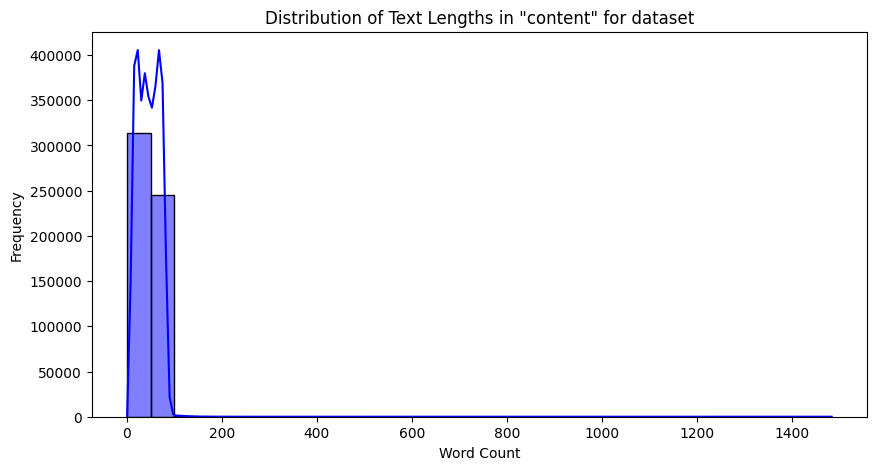

count    560000.000000
mean         46.133234
std          22.469181
min           1.000000
25%          27.000000
50%          46.000000
75%          65.000000
max        1484.000000
Name: content, dtype: float64


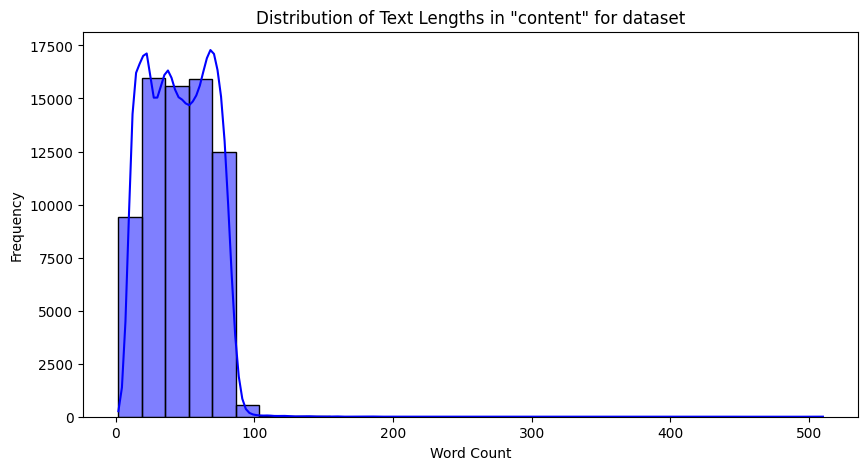

count    70000.000000
mean        46.141457
std         22.363864
min          2.000000
25%         27.000000
50%         46.000000
75%         65.000000
max        510.000000
Name: content, dtype: float64


In [5]:
# %% [code]
# EDA: Text length analysis using the "content" column
def text_length_analysis(df, column='content'):
    lengths = df[column].astype(str).apply(lambda x: len(x.split()))
    plt.figure(figsize=(10, 5))
    sns.histplot(lengths, bins=30, kde=True, color='blue')
    plt.title(f'Distribution of Text Lengths in "{column}" for dataset')
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    plt.show()
    print(lengths.describe())

text_length_analysis(train_df, 'content')
text_length_analysis(test_df, 'content')


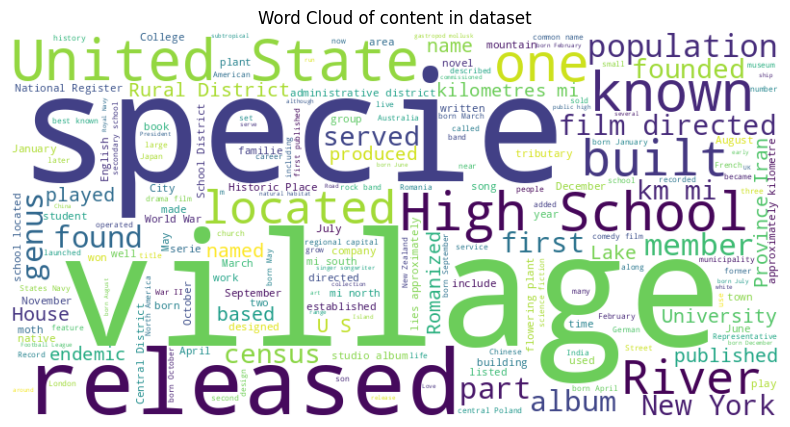

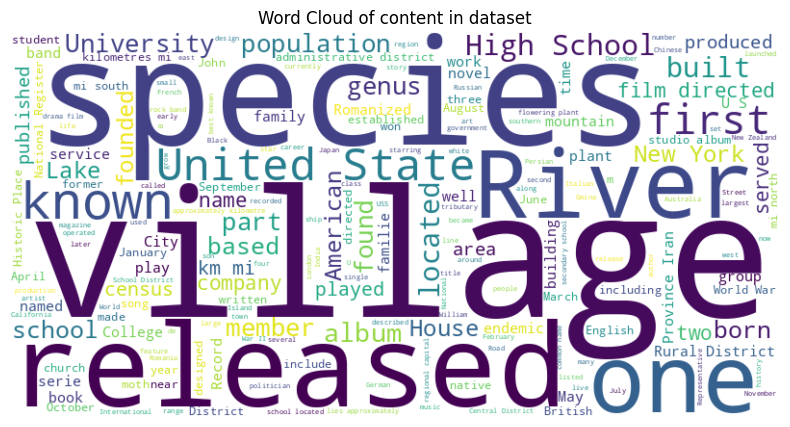

In [6]:
# %% [code]
# EDA: Generate Word Cloud for text in "content"
def generate_wordcloud(df, column='content'):
    text = " ".join(df[column].astype(str).values)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud of {column} in dataset')
    plt.show()

generate_wordcloud(train_df, 'content')
generate_wordcloud(test_df, 'content')


In [7]:
# %% [code]
# EDA: Top 20 most common words in the "content" column
def most_common_words(df, column='content', n=20):
    text = " ".join(df[column].astype(str).str.lower().values)
    words = re.findall(r'\b[a-z]{3,}\b', text)
    common_words = Counter(words).most_common(n)
    for i, (word, freq) in enumerate(common_words, 1):
        print(f"{i}. {word} - {freq}")

print("Top 20 words in Train Set:")
most_common_words(train_df, 'content')
print("\nTop 20 words in Test Set:")
most_common_words(test_df, 'content')


Top 20 words in Train Set:
1. the - 1666844
2. and - 722292
3. was - 386398
4. for - 173675
5. from - 128748
6. with - 117083
7. school - 101753
8. born - 84149
9. film - 78437
10. district - 77696
11. its - 75008
12. also - 74482
13. album - 69683
14. known - 65171
15. has - 64947
16. his - 64507
17. first - 62156
18. species - 62052
19. family - 61995
20. county - 60846

Top 20 words in Test Set:
1. the - 208074
2. and - 90142
3. was - 48219
4. for - 21997
5. from - 15887
6. with - 14396
7. school - 12613
8. born - 10418
9. district - 9782
10. film - 9617
11. also - 9364
12. its - 9349
13. album - 8706
14. has - 8236
15. his - 8147
16. known - 8126
17. first - 7887
18. species - 7774
19. family - 7717
20. county - 7547


In [8]:
# %% [code]
# Prepare limited labeled data for semi-supervised learning.
# For example, select 10 labeled examples per class.
labeled_per_class = 10  
classes = sorted(train_df['label'].unique())
labeled_indices = []

for c in classes:
    class_indices = train_df[train_df['label'] == c].index
    if len(class_indices) <= labeled_per_class:
        chosen = class_indices
    else:
        chosen = np.random.choice(class_indices, size=labeled_per_class, replace=False)
    labeled_indices.extend(chosen)
    
labeled_df = train_df.loc[labeled_indices].copy().reset_index(drop=True)
unlabeled_df = train_df.drop(labeled_indices).copy().reset_index(drop=True)

print(f"Using {len(labeled_df)} labeled examples out of {len(train_df)} for training.")
print(f"Unlabeled training examples: {len(unlabeled_df)}")


Using 140 labeled examples out of 560000 for training.
Unlabeled training examples: 559860


In [9]:
# %% [code]
# Define tokenization and augmentation functions
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def weak_augment(text: str) -> str:
    return text  # identity function for weak augmentation

def strong_augment(text: str) -> str:
    words = text.split()
    if len(words) > 1:
        new_words = [w for w in words if random.random() > 0.15]
        if not new_words:
            new_words = [random.choice(words)]
        num_swaps = max(1, int(0.1 * len(new_words))) if len(new_words) > 1 else 0
        for _ in range(num_swaps):
            i, j = random.sample(range(len(new_words)), 2)
            new_words[i], new_words[j] = new_words[j], new_words[i]
        aug_text = " ".join(new_words)
    else:
        aug_text = text
    return aug_text

class TextDataset(Dataset):
    def __init__(self, df: pd.DataFrame, tokenizer: BertTokenizer, max_len: int = 128):
        self.texts = df['content'].astype(str).tolist()
        self.labels = df['label'].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]
        encodings = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        input_ids = encodings['input_ids'].squeeze(0)
        attention_mask = encodings['attention_mask'].squeeze(0)
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': torch.tensor(label, dtype=torch.long)
        }

class UnlabeledTextDataset(Dataset):
    def __init__(self, df: pd.DataFrame, tokenizer: BertTokenizer, max_len: int = 128):
        self.texts = df['content'].astype(str).tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, index):
        text = self.texts[index]
        weak_text = weak_augment(text)
        strong_text = strong_augment(text)
        weak_enc = self.tokenizer(
            weak_text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        strong_enc = self.tokenizer(
            strong_text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        weak_ids = weak_enc['input_ids'].squeeze(0)
        weak_mask = weak_enc['attention_mask'].squeeze(0)
        strong_ids = strong_enc['input_ids'].squeeze(0)
        strong_mask = strong_enc['attention_mask'].squeeze(0)
        return {
            'weak_input_ids': weak_ids,
            'weak_attention_mask': weak_mask,
            'strong_input_ids': strong_ids,
            'strong_attention_mask': strong_mask
        }


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
# %% [code]
# Define tokenization and augmentation functions
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def weak_augment(text: str) -> str:
    return text  # identity function for weak augmentation

def strong_augment(text: str) -> str:
    words = text.split()
    if len(words) > 1:
        new_words = [w for w in words if random.random() > 0.15]
        if not new_words:
            new_words = [random.choice(words)]
        num_swaps = max(1, int(0.1 * len(new_words))) if len(new_words) > 1 else 0
        for _ in range(num_swaps):
            i, j = random.sample(range(len(new_words)), 2)
            new_words[i], new_words[j] = new_words[j], new_words[i]
        aug_text = " ".join(new_words)
    else:
        aug_text = text
    return aug_text

class TextDataset(Dataset):
    def __init__(self, df: pd.DataFrame, tokenizer: BertTokenizer, max_len: int = 128):
        self.texts = df['content'].astype(str).tolist()
        self.labels = df['label'].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]
        encodings = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        input_ids = encodings['input_ids'].squeeze(0)
        attention_mask = encodings['attention_mask'].squeeze(0)
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': torch.tensor(label, dtype=torch.long)
        }

class UnlabeledTextDataset(Dataset):
    def __init__(self, df: pd.DataFrame, tokenizer: BertTokenizer, max_len: int = 128):
        self.texts = df['content'].astype(str).tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, index):
        text = self.texts[index]
        weak_text = weak_augment(text)
        strong_text = strong_augment(text)
        weak_enc = self.tokenizer(
            weak_text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        strong_enc = self.tokenizer(
            strong_text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        weak_ids = weak_enc['input_ids'].squeeze(0)
        weak_mask = weak_enc['attention_mask'].squeeze(0)
        strong_ids = strong_enc['input_ids'].squeeze(0)
        strong_mask = strong_enc['attention_mask'].squeeze(0)
        return {
            'weak_input_ids': weak_ids,
            'weak_attention_mask': weak_mask,
            'strong_input_ids': strong_ids,
            'strong_attention_mask': strong_mask
        }


In [11]:
# %% [code]
# Create DataLoaders
batch_size_labeled = 16
unlabeled_ratio = 5  
batch_size_unlabeled = batch_size_labeled * unlabeled_ratio
batch_size_test = 32

labeled_dataset = TextDataset(labeled_df, tokenizer, max_len=128)
unlabeled_dataset = UnlabeledTextDataset(unlabeled_df, tokenizer, max_len=128)
test_dataset = TextDataset(test_df, tokenizer, max_len=128)

labeled_loader = DataLoader(labeled_dataset, batch_size=batch_size_labeled, shuffle=True, drop_last=True)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size_unlabeled, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)


In [12]:
# %% [code]
# Define the BERT-based classifier model.
class TextClassifier(nn.Module):
    def __init__(self, pretrained_model_name: str, num_classes: int):
        super(TextClassifier, self).__init__()
        self.encoder = BertModel.from_pretrained(pretrained_model_name)
        self.classifier = nn.Linear(self.encoder.config.hidden_size, num_classes)
    
    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
            features = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(features)
        return logits
    
    def train(self, mode=True):
        super(TextClassifier, self).train(mode)
        self.encoder.eval()
        return self

num_classes = len(train_df['label'].unique())
print("Number of classes:", num_classes)

model_f = TextClassifier("bert-base-uncased", num_classes=num_classes)
model_g = TextClassifier("bert-base-uncased", num_classes=num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_f.to(device)
model_g.to(device)

for param in model_f.encoder.parameters():
    param.requires_grad = False
for param in model_g.encoder.parameters():
    param.requires_grad = False

model_f.train()
model_g.train()


Number of classes: 14


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

TextClassifier(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [13]:
# %% [code]
# Define loss, optimizer, and JointMatch training configuration.
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = optim.Adam(list(model_f.classifier.parameters()) + list(model_g.classifier.parameters()), lr=learning_rate)

epochs = 4
lambda_m = 0.9       # Momentum for moving average update
base_threshold = 0.95
delta = 0.9          # Disagreement weight
unlabeled_loss_weight = 1.0

p_hat_f = torch.ones(num_classes, device=device) / num_classes
p_hat_g = torch.ones(num_classes, device=device) / num_classes

for epoch in range(epochs):
    model_f.train()
    model_g.train()
    running_loss = 0.0
    labeled_iter = iter(labeled_loader)
    
    for batch_idx, unl_batch in enumerate(unlabeled_loader):
        try:
            lab_batch = next(labeled_iter)
        except StopIteration:
            labeled_iter = iter(labeled_loader)
            lab_batch = next(labeled_iter)
        
        lab_input_ids = lab_batch['input_ids'].to(device)
        lab_attention_mask = lab_batch['attention_mask'].to(device)
        lab_labels = lab_batch['label'].to(device)
        
        weak_ids = unl_batch['weak_input_ids'].to(device)
        weak_mask = unl_batch['weak_attention_mask'].to(device)
        strong_ids = unl_batch['strong_input_ids'].to(device)
        strong_mask = unl_batch['strong_attention_mask'].to(device)
        
        # Supervised loss on labeled batch for both models
        logits_f_lab = model_f(lab_input_ids, lab_attention_mask)
        logits_g_lab = model_g(lab_input_ids, lab_attention_mask)
        loss_sup_f = criterion(logits_f_lab, lab_labels)
        loss_sup_g = criterion(logits_g_lab, lab_labels)
        
        # Unlabeled data: weakly-augmented pass
        logits_f_weak = model_f(weak_ids, weak_mask)
        logits_g_weak = model_g(weak_ids, weak_mask)
        prob_f = F.softmax(logits_f_weak, dim=1)
        prob_g = F.softmax(logits_g_weak, dim=1)
        max_probs_f, pseudo_label_f = torch.max(prob_f, dim=1)
        max_probs_g, pseudo_label_g = torch.max(prob_g, dim=1)
        
        # Update moving average estimates for adaptive thresholds
        batch_mean_f = prob_f.mean(dim=0)
        batch_mean_g = prob_g.mean(dim=0)
        p_hat_f = lambda_m * p_hat_f + (1 - lambda_m) * batch_mean_f.detach()
        p_hat_g = lambda_m * p_hat_g + (1 - lambda_m) * batch_mean_g.detach()
        
        tau_f = (p_hat_f / torch.max(p_hat_f)) * base_threshold
        tau_g = (p_hat_g / torch.max(p_hat_g)) * base_threshold
        
        valid_f_mask = (max_probs_f >= tau_f[pseudo_label_f]).float()
        valid_g_mask = (max_probs_g >= tau_g[pseudo_label_g]).float()
        
        disagree_mask = (pseudo_label_f != pseudo_label_g).float()
        w = delta * disagree_mask + (1 - delta) * (1 - disagree_mask)
        
        # Unlabeled data: strongly-augmented pass
        logits_f_strong = model_f(strong_ids, strong_mask)
        logits_g_strong = model_g(strong_ids, strong_mask)
        
        loss_f_all = F.cross_entropy(logits_f_strong, pseudo_label_g.to(device), reduction='none')
        loss_g_all = F.cross_entropy(logits_g_strong, pseudo_label_f.to(device), reduction='none')
        
        loss_f_masked = w * valid_g_mask * loss_f_all
        loss_g_masked = w * valid_f_mask * loss_g_all
        
        loss_unsup_f = loss_f_masked.mean()
        loss_unsup_g = loss_g_masked.mean()
        
        loss_f_total = loss_sup_f + unlabeled_loss_weight * loss_unsup_f
        loss_g_total = loss_sup_g + unlabeled_loss_weight * loss_unsup_g
        
        total_loss = loss_f_total + loss_g_total
        
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        running_loss += total_loss.item()
    
    avg_loss = running_loss / len(unlabeled_loader)
    print(f"Epoch {epoch+1}/{epochs} - Average training loss: {avg_loss:.4f}")


Epoch 1/4 - Average training loss: 0.4759
Epoch 2/4 - Average training loss: 0.0193
Epoch 3/4 - Average training loss: 0.0108
Epoch 4/4 - Average training loss: 0.0095


In [14]:
# %% [code]
# Evaluation function for test set
def evaluate_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in dataloader:
            ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(ids, mask)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

acc_f = evaluate_model(model_f, test_loader, device)
acc_g = evaluate_model(model_g, test_loader, device)
print(f"Test Accuracy of Model F: {acc_f*100:.2f}%")
print(f"Test Accuracy of Model G: {acc_g*100:.2f}%")

# Ensemble evaluation: average predictions of both models
model_f.eval()
model_g.eval()
correct_ens = 0
total_ens = 0
with torch.no_grad():
    for batch in test_loader:
        ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        logits_f = model_f(ids, mask)
        logits_g = model_g(ids, mask)
        avg_logits = (logits_f + logits_g) / 2
        preds = torch.argmax(avg_logits, dim=1)
        correct_ens += (preds == labels).sum().item()
        total_ens += labels.size(0)
acc_ens = correct_ens / total_ens
print(f"Test Accuracy of F+G Ensemble: {acc_ens*100:.2f}%")


Test Accuracy of Model F: 96.43%
Test Accuracy of Model G: 96.42%
Test Accuracy of F+G Ensemble: 96.42%
